In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/umap/distanc

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/'
output_folder = './output_data/'

In [4]:
dataset_name = 'scMNC-Motor'
dataset_color = 'sienna'
modality_names = ['Gene Expression', 'Electrophysiology']
data_folder = '../data/scMNC/mouse_motor_cortex/data/'
data1 = pd.read_csv(data_folder + "geneExp_filtered.csv")
data2 = pd.read_csv(data_folder + "efeature_filtered.csv")
feat1 = np.array(data1.iloc[:, 0])
feat2 = np.array(data2.columns)
sample_names1 = data1.columns[1:]
assert ((data1.shape[1] - 1) == data2.shape[0])
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)
meta = pd.read_excel(data_folder + "motor_meta_data.xlsx")[['Cell', 'RNA family']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split()[0] for x in meta[meta_idx, 1]])

# Sampling
# split = 1000 # data1.shape[0]
# data_col_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [feat1, feat2]
feature_dict = {}

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 256,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    'dropout': 0,
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [8]:
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

use random seed: 666
Shape of Raw data
Dataset 0: (1208, 1286)
Dataset 1: (1208, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.3861 alpha:0.0050
epoch:[1000/2000] err:3.3359 alpha:0.0249
epoch:[1500/2000] err:5.7469 alpha:0.0598
epoch:[2000/2000] err:7.0836 alpha:0.0926
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 29, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0014  Rec: 0.6235  CosSim: 0.1924  F: 0.0128
Epoch: 200 - KL: 0.0026  Rec: 0.3537  CosSim: 0.0790  F: 0.0073
Epoch: 300 - KL: 0.0047  Rec: 0.2281  CosSim: 0.0517  F: 0.0064
Epoch: 400 - KL: 0.0077  Rec: 0.1608  CosSim: 0.0402  F: 0.0053
Epoch: 500 - KL: 0.0115  Rec: 0.1510  CosSim: 0.0322  F: 0.0046
epoch:[500/10000]: loss:0.203248
Epoch: 600 - KL: 0.0189  Rec: 0.1458  CosSim: 0.0279  F: 0.0039
Epoch: 700 - KL: 0.0277  Rec: 0.1187  CosSim: 0.0225  F: 0.0034
Epoch: 800 - KL: 0.0388  Rec: 0.1183  CosSim: 0.0241  F: 0.0029
Epoch: 900 - KL: 0.0560  Rec: 0.1025  CosSim: 0.0218  F: 0.0029
Epoch: 1000 - KL: 0.0750  Rec: 0.1066  CosSim: 0.0212  F: 0.0029
epoch:[1000/10000]: loss:0.210990
Epoch: 1100 - KL: 0.0988  Rec: 0.0927  CosSim: 0.0210  F: 0.0033
Epoch: 1200 - KL: 0.1097  Rec: 0.1072  CosSim: 0.0250  F: 0.0033
Epoch: 1300 - KL: 0.1285  Rec: 0.1047  CosSim: 0.0296  F: 0.0034
Epoch: 1400 - KL: 0.1436  Rec: 0.1065  CosSim: 0.0286  F: 0.0033
Epoch: 1500 - KL: 0.1647  Rec: 0

In [9]:
# Integration (.75)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_75---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_75 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_75.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_75_data = jm_75.fit_transform(dataset=dataset, P=tq_priors)
    jm_75.save_model(model_str)
    np.save(match_str, jm_75.match_result, allow_pickle=True)
jm_75_data = jm_75.transform(dataset=dataset)
integrated_data.append(jm_75_data)
integrated_names.append( 'JAMIE (.75)')
colors.append('lawngreen')
shapes.append('^')

use random seed: 666
Shape of Raw data
Dataset 0: (1208, 1286)
Dataset 1: (1208, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.3861 alpha:0.0050
epoch:[1000/2000] err:3.3359 alpha:0.0249
epoch:[1500/2000] err:5.7469 alpha:0.0598
epoch:[2000/2000] err:7.0836 alpha:0.0926
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 29, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0011  Rec: 0.5708  CosSim: 0.0697  F: 0.0247
Epoch: 200 - KL: 0.0026  Rec: 0.2908  CosSim: 0.0253  F: 0.0134
Epoch: 300 - KL: 0.0035  Rec: 0.1921  CosSim: 0.0216  F: 0.0097
Epoch: 400 - KL: 0.0058  Rec: 0.1530  CosSim: 0.0103  F: 0.0080
Epoch: 500 - KL: 0.0076  Rec: 0.1265  CosSim: 0.0083  F: 0.0070
epoch:[500/10000]: loss:0.164523
Epoch: 600 - KL: 0.0103  Rec: 0.1224  CosSim: 0.0083  F: 0.0066
Epoch: 700 - KL: 0.0095  Rec: 0.1256  CosSim: 0.0073  F: 0.0052
Epoch: 800 - KL: 0.0147  Rec: 0.1186  CosSim: 0.0060  F: 0.0055
Epoch: 900 - KL: 0.0134  Rec: 0.1114  CosSim: 0.0107  F: 0.0063
Epoch: 1000 - KL: 0.0164  Rec: 0.1017  CosSim: 0.0092  F: 0.0059
epoch:[1000/10000]: loss:0.139953
Epoch: 1100 - KL: 0.0191  Rec: 0.0893  CosSim: 0.0074  F: 0.0060
Epoch: 1200 - KL: 0.0158  Rec: 0.0957  CosSim: 0.0251  F: 0.0059
Epoch: 1300 - KL: 0.0147  Rec: 0.0897  CosSim: 0.0068  F: 0.0059
Epoch: 1400 - KL: 0.0136  Rec: 0.0767  CosSim: 0.0071  F: 0.0066
Epoch: 1500 - KL: 0.0122  Rec: 0

In [10]:
# Integration (.5)
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm_50---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_50 = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_50.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_50_data = jm_50.fit_transform(dataset=dataset, P=half_priors)
    jm_50.save_model(model_str)
    np.save(match_str, jm_50.match_result, allow_pickle=True)
jm_50_data = jm_50.transform(dataset=dataset)
integrated_data.append(jm_50_data)
integrated_names.append( 'JAMIE (.5)')
colors.append('midnightblue')
shapes.append('d')

use random seed: 666
Shape of Raw data
Dataset 0: (1208, 1286)
Dataset 1: (1208, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.3861 alpha:0.0050
epoch:[1000/2000] err:3.3359 alpha:0.0249
epoch:[1500/2000] err:5.7469 alpha:0.0598
epoch:[2000/2000] err:7.0836 alpha:0.0926
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 29, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0008  Rec: 0.5276  CosSim: 0.0658  F: 0.0273
Epoch: 200 - KL: 0.0019  Rec: 0.2684  CosSim: 0.0205  F: 0.0153
Epoch: 300 - KL: 0.0028  Rec: 0.1896  CosSim: 0.0192  F: 0.0103
Epoch: 400 - KL: 0.0043  Rec: 0.1370  CosSim: 0.0080  F: 0.0091
Epoch: 500 - KL: 0.0060  Rec: 0.1157  CosSim: 0.0064  F: 0.0072
epoch:[500/10000]: loss:0.141827
Epoch: 600 - KL: 0.0068  Rec: 0.1129  CosSim: 0.0080  F: 0.0075
Epoch: 700 - KL: 0.0093  Rec: 0.1064  CosSim: 0.0046  F: 0.0054
Epoch: 800 - KL: 0.0116  Rec: 0.1109  CosSim: 0.0077  F: 0.0058
Epoch: 900 - KL: 0.0117  Rec: 0.0992  CosSim: 0.0150  F: 0.0063
Epoch: 1000 - KL: 0.0135  Rec: 0.0884  CosSim: 0.0055  F: 0.0058
epoch:[1000/10000]: loss:0.114836
Epoch: 1100 - KL: 0.0145  Rec: 0.0829  CosSim: 0.0063  F: 0.0065
Epoch: 1200 - KL: 0.0139  Rec: 0.0848  CosSim: 0.0220  F: 0.0066
Epoch: 1300 - KL: 0.0162  Rec: 0.0804  CosSim: 0.0042  F: 0.0070
Epoch: 1400 - KL: 0.0112  Rec: 0.0729  CosSim: 0.0230  F: 0.0077
Epoch: 1500 - KL: 0.0102  Rec: 0

In [11]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (966, 1286)
Dataset 1: (966, 29)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:2.3039 alpha:0.0197
epoch:[1000/2000] err:5.0079 alpha:0.0502
epoch:[1500/2000] err:6.3796 alpha:0.0817
epoch:[2000/2000] err:7.0486 alpha:0.1084
Finished Matching!
---------------------------------
Train coupled autoencoders


/mnt/c/Users/nck/repos/nmacom/jamie/jamie.py:428: UserWarning: PCA dim must be lower than 29, found 512, adjusting to compensate.
  warnings.warn(


Epoch: 100 - KL: 0.0011  Rec: 1.4774  CosSim: 0.6075  F: 0.0106
Epoch: 200 - KL: 0.0029  Rec: 1.4931  CosSim: 0.1560  F: 0.0037
Epoch: 300 - KL: 0.0072  Rec: 1.4758  CosSim: 0.1169  F: 0.0028
Epoch: 400 - KL: 0.0076  Rec: 1.4523  CosSim: 0.0925  F: 0.0022
Epoch: 500 - KL: 0.0115  Rec: 1.2990  CosSim: 0.0810  F: 0.0026
epoch:[500/10000]: loss:1.437216
Epoch: 600 - KL: 0.0313  Rec: 1.3150  CosSim: 0.0524  F: 0.0017
Epoch: 700 - KL: 0.0384  Rec: 1.2595  CosSim: 0.0518  F: 0.0015
Epoch: 800 - KL: 0.0476  Rec: 1.1942  CosSim: 0.0561  F: 0.0016
Epoch: 900 - KL: 0.0677  Rec: 1.2126  CosSim: 0.0636  F: 0.0017
Epoch: 1000 - KL: 0.0995  Rec: 1.2078  CosSim: 0.0744  F: 0.0016
epoch:[1000/10000]: loss:1.366060
Epoch: 1100 - KL: 0.1436  Rec: 1.2369  CosSim: 0.0678  F: 0.0020
Epoch: 1200 - KL: 0.1337  Rec: 1.2025  CosSim: 0.0835  F: 0.0017
Epoch: 1300 - KL: 0.1079  Rec: 1.2194  CosSim: 0.0791  F: 0.0016
Epoch: 1400 - KL: 0.1464  Rec: 1.1382  CosSim: 0.0670  F: 0.0016
Epoch: 1500 - KL: 0.1958  Rec: 1

# Comparison Methods

In [12]:
from sklearn.decomposition import PCA

# PCA features for algs that need it (To Revise)
max_feat = 10000
dataset_mini = dataset.copy()
pca_mini = []
for i in range(len(dataset_mini)):
    if dataset[i].shape[1] > max_feat:
        n_components = min(max_feat, dataset[i].shape[0])
        pca = PCA(n_components=n_components)
        dataset_mini[i] = pca.fit_transform(dataset[i])
        # dataset_mini[i] = np.zeros((dataset[i].shape[0], n_components))
        pca_mini.append(pca)

In [13]:
method_name, method_color, method_shape = 'NLMA', 'red', 'X'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _ = mmd_combine(*in_data, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [14]:
method_name, method_color, method_shape = 'LMA', 'orange', '*'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [15]:
method_name, method_color, method_shape = 'CCA', 'm', 'D'
in_data = dataset_mini
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

In [16]:
method_name, method_color, method_shape = 'MMD-MA', 'cyan', 'P'
in_data = dataset
in_data = [d / np.linalg.norm(d, axis=1).reshape(-1, 1) for d in in_data]
in_data = [np.matmul(d, d.T) for d in in_data]
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='mmd_ma', p=reduced_dim, max_iterations=10001)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

2023-08-18 19:01:57.743005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-18 19:01:57.743044: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 19:01:57.743056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2023-08-18 19:01:57.743390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 19:01:57.753174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:

In [17]:
method_name, method_color, method_shape = 'UnionCom', 'green', 's'
in_data = dataset
method_str = '---'.join([method_name, dataset_name, '-'.join([str(s) for s in in_data[0].shape]), '-'.join([str(s) for s in in_data[1].shape])])
method_str = output_folder + method_str + '.npy'
try:
    data = np.load(method_str)
    print(f'Loaded data \'{method_str}\'')
except FileNotFoundError:
    data, _, _ = mmd_combine(*in_data, method='unioncom', output_dim=reduced_dim)
    np.save(method_str, data)
integrated_data.append(data)
integrated_names.append(method_name)
colors.append(method_color)
shapes.append(method_shape)

use random seed: 666
Shape of Raw data
Dataset 0: (1208, 1286)
Dataset 1: (1208, 29)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:6.7474 alpha:4.0838
epoch:[200/2000] err:0.9040 alpha:0.5471
epoch:[300/2000] err:0.1211 alpha:0.0733
epoch:[400/2000] err:0.0162 alpha:0.0098
epoch:[500/2000] err:0.0268 alpha:0.0162
epoch:[600/2000] err:0.0416 alpha:0.0252
epoch:[700/2000] err:0.0575 alpha:0.0348
epoch:[800/2000] err:0.0739 alpha:0.0447
epoch:[900/2000] err:0.0904 alpha:0.0548
epoch:[1000/2000] err:0.1069 alpha:0.0647
epoch:[1100/2000] err:0.1229 alpha:0.0745
epoch:[1200/2000] err:0.1383 alpha:0.0838
epoch:[1300/2000] err:0.1530 alpha:0.0928
epoch:[1400/2000] err:0.1669 alpha:0.1013
epoch:[1500/2000] err:0.1800 alpha:0.1094
epoch:[1600/2000] err:0.1923 alpha:0.1169
epoch:[1700/2000] err:0.2037 alpha:0.1240
epoch:[1800/2000] err:0.2142 alpha:0.1305
epoch:[1900/2000] err:0.2240 alpha:0.1367
epoch:[2000/2000] err:0.

In [18]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'KNN'
    nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]
imputed_data_full = [jm_imputed, nn_imputed][::-1]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE', imputation_name][::-1]

# Visualization

In [19]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'svg.fonttype': 'none',
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})
sns.set_palette('husl', len(np.unique(labels)))

In [20]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-LabelLegend.svg', bbox_inches=bbox, format='svg')

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.svg', bbox_inches=bbox, format='svg')

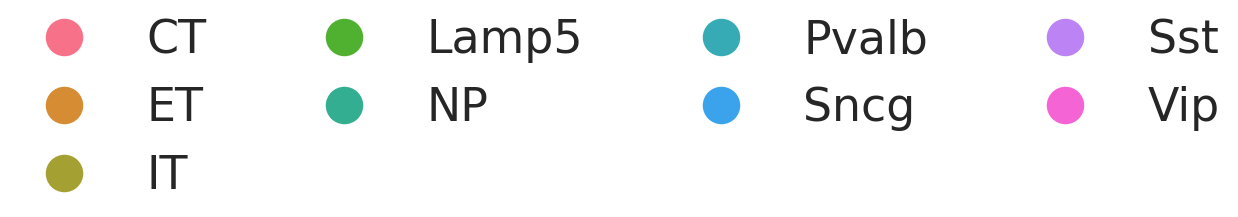

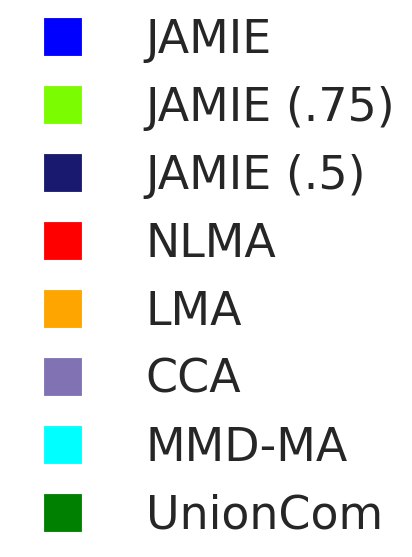

In [21]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

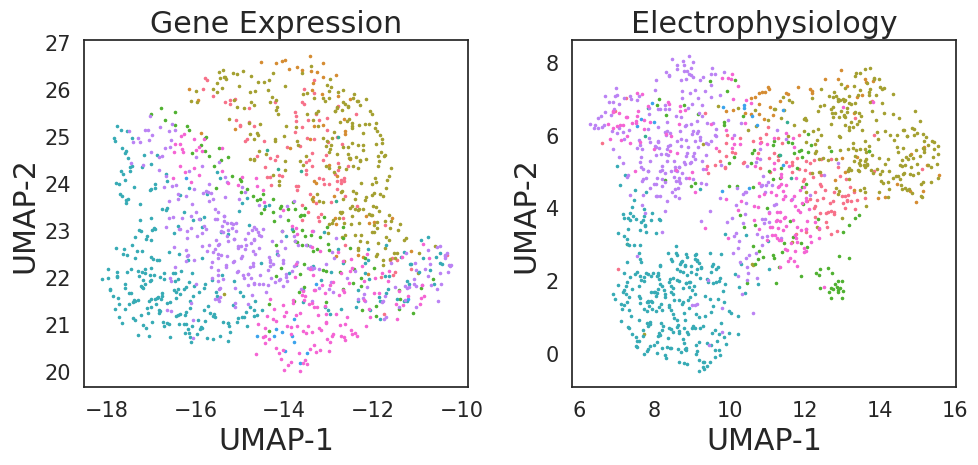

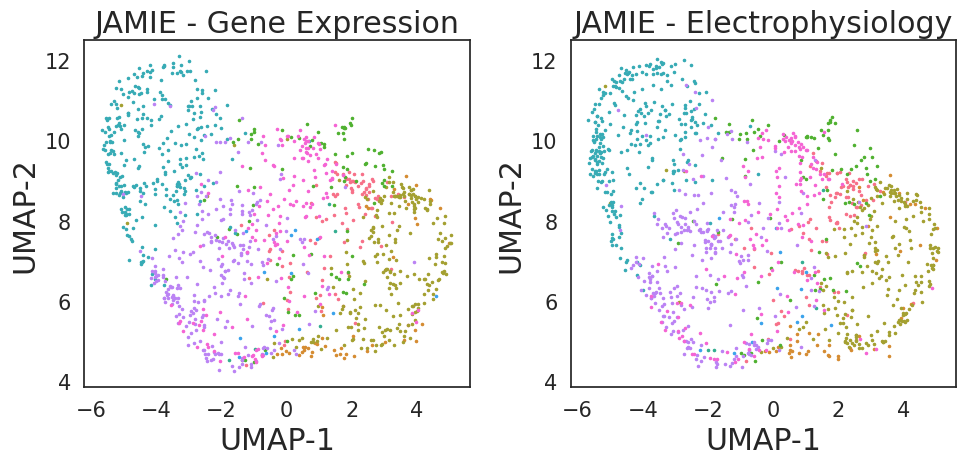

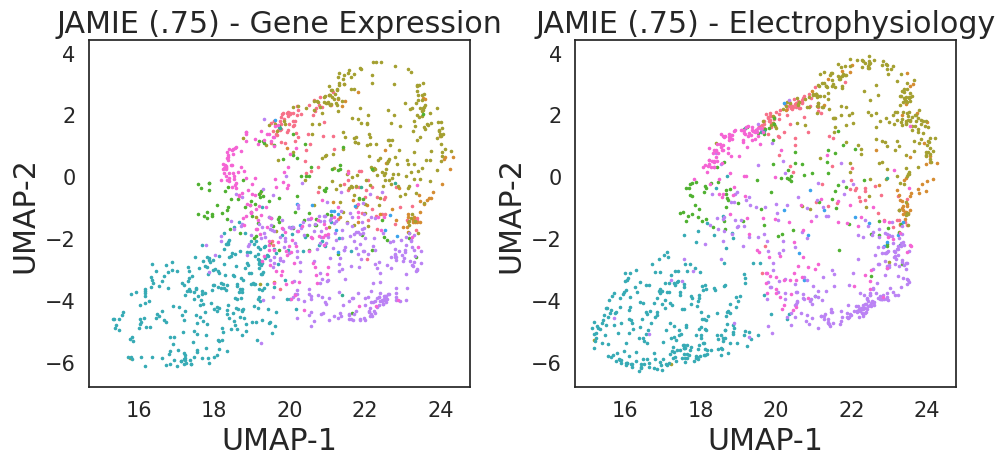

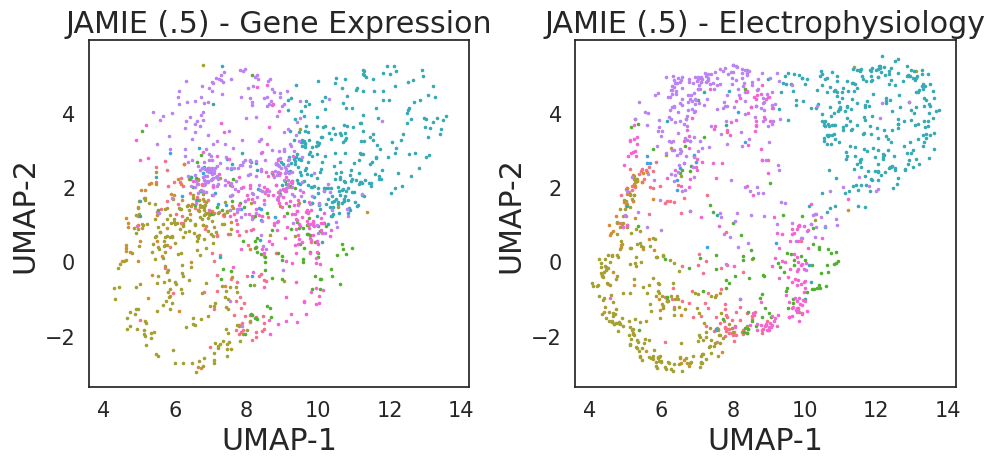

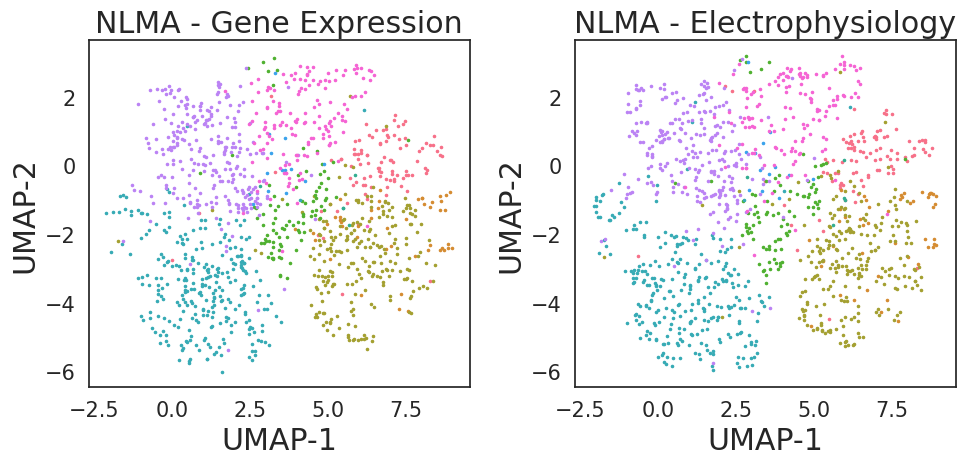

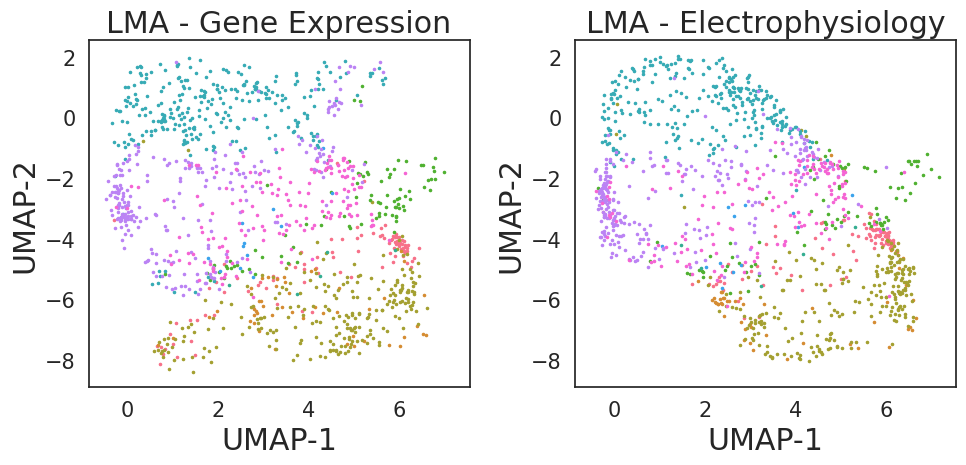

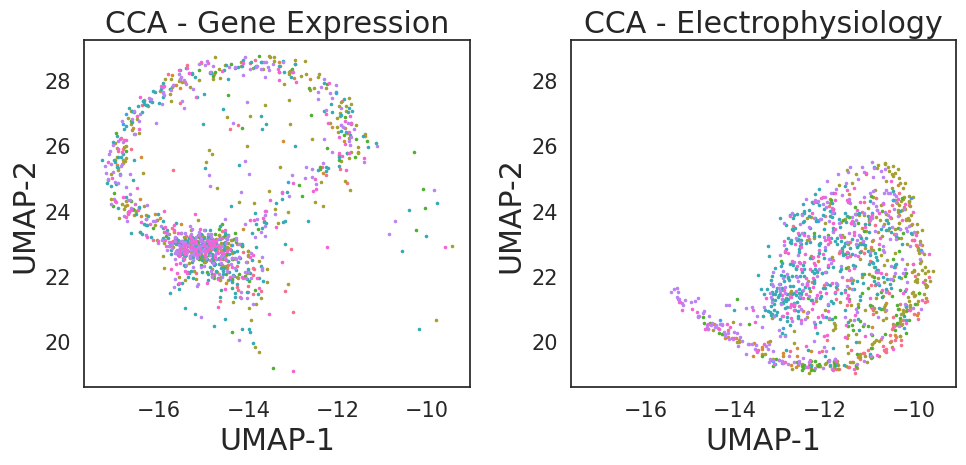

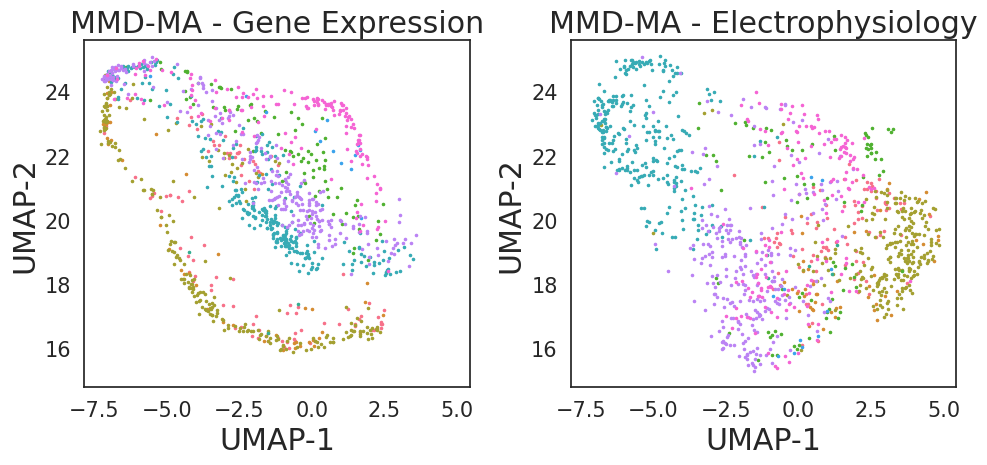

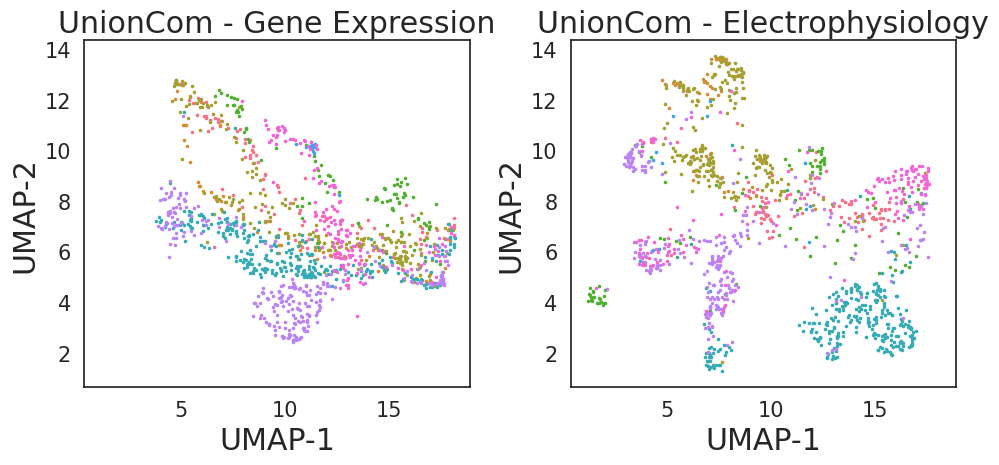

In [22]:
# Raw data
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Data.svg', format='svg', bbox_inches='tight')

# Integrated data
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.savefig(image_folder + dataset_name + f'-{n}.svg', format='svg', bbox_inches='tight')
    plt.show()

Algorithm     JAMIE      NLMA       LMA       CCA    MMD-MA  UnionCom
FOSCTTM    0.002500  0.000846  0.043943  0.362291  0.478149  0.486099
LTA        0.895695  0.924669  0.896523  0.287252  0.246689  0.173013
Algorithm     JAMIE  JAMIE (.75)  JAMIE (.5)      NLMA       LMA       CCA  \
FOSCTTM    0.002500     0.064138    0.139257  0.000846  0.043943  0.362291   
LTA        0.895695     0.828642    0.759934  0.924669  0.896523  0.287252   

Algorithm    MMD-MA  UnionCom  
FOSCTTM    0.478149  0.486099  
LTA        0.246689  0.173013  


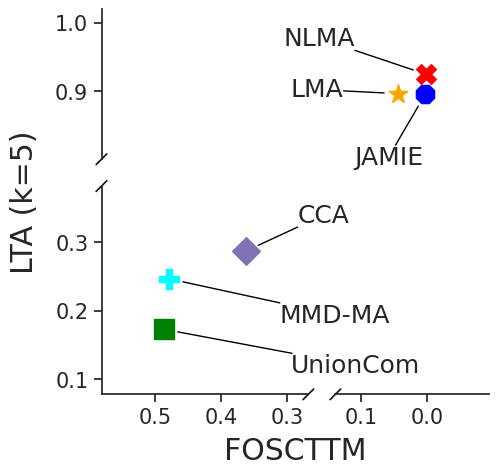

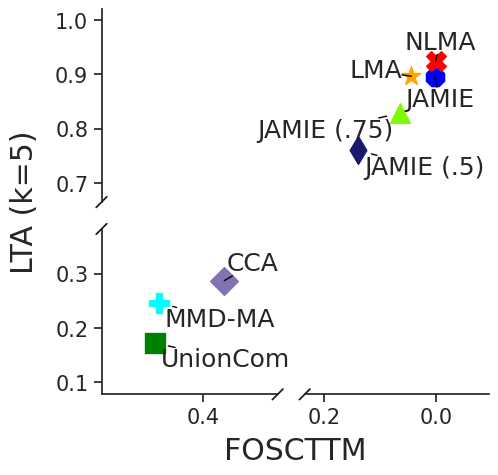

In [23]:
with_idx = [i for i in range(len(integrated_data)) if i not in (1, 2)]
# Without Partial
plt.figure(figsize=(5, 5))
idx = with_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx], expand_points=(2., 2.))
plt.savefig(image_folder + dataset_name + '-Acc.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Acc.svg', format='svg', bbox_inches='tight')

without_idx = list(range(len(integrated_data)))
# With Partial
plt.figure(figsize=(5, 5))
idx = without_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccPartial.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccPartial.svg', format='svg', bbox_inches='tight')

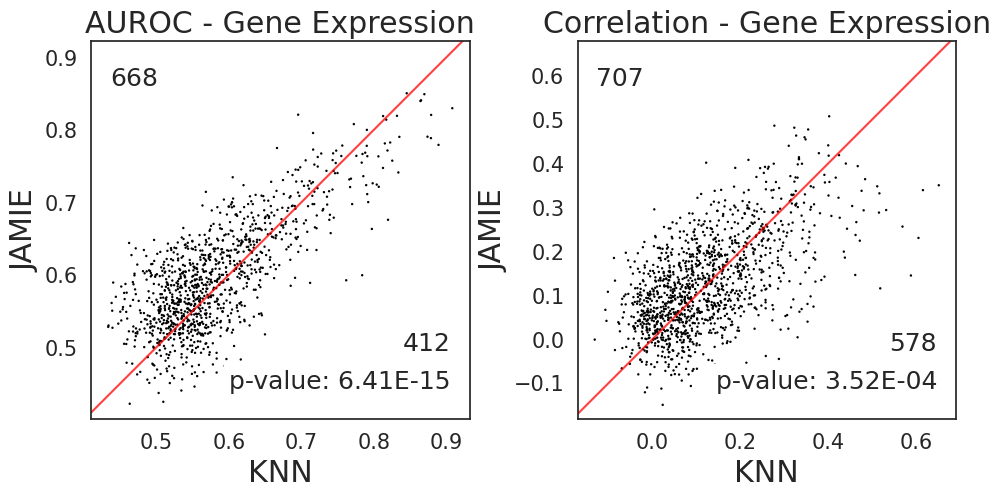

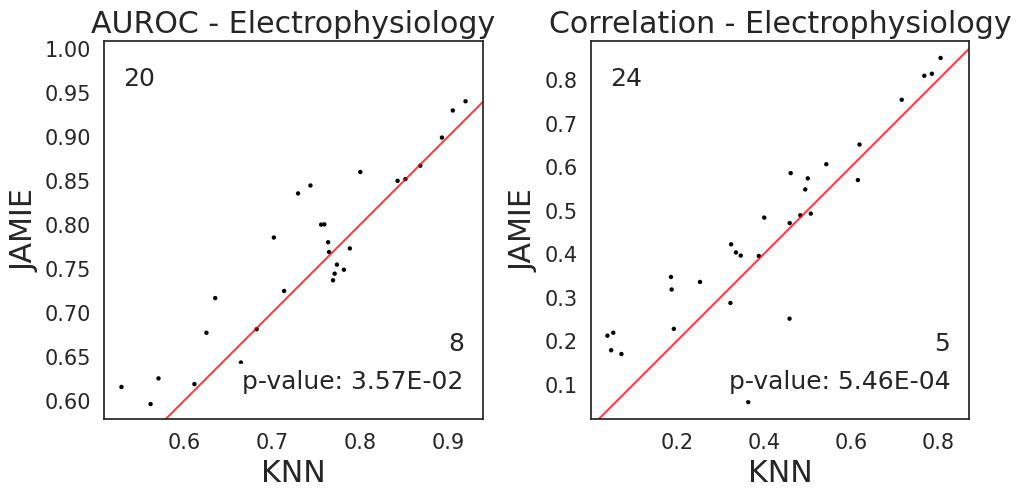

In [24]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2.svg', format='svg', bbox_inches='tight')

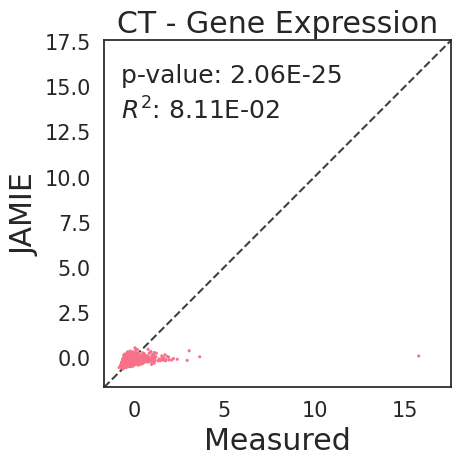

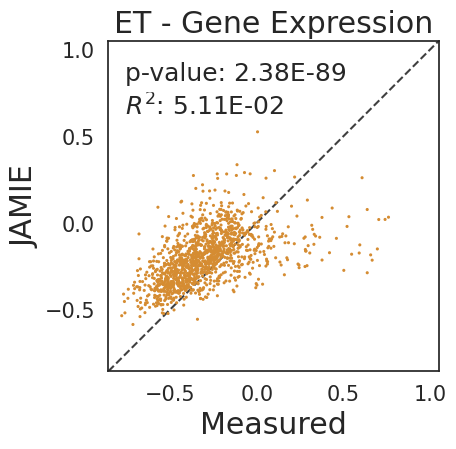

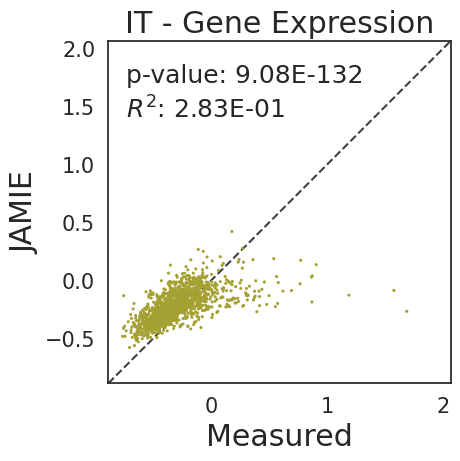

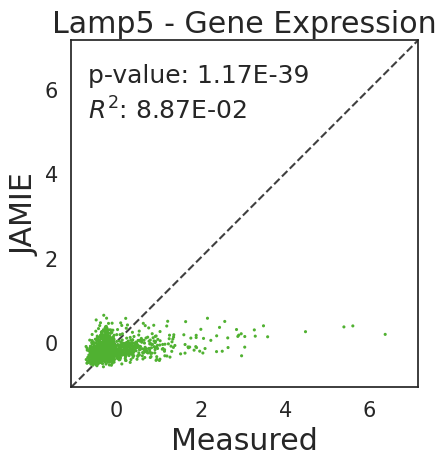

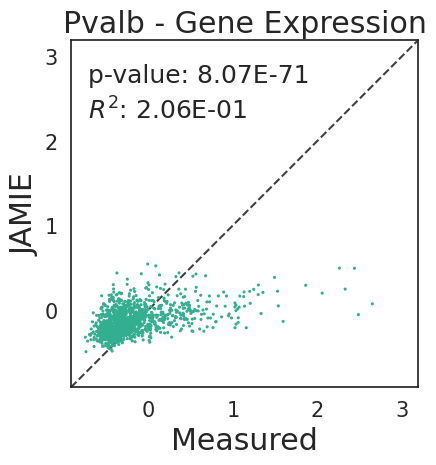

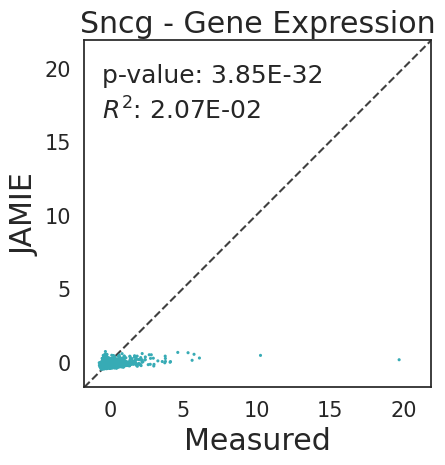

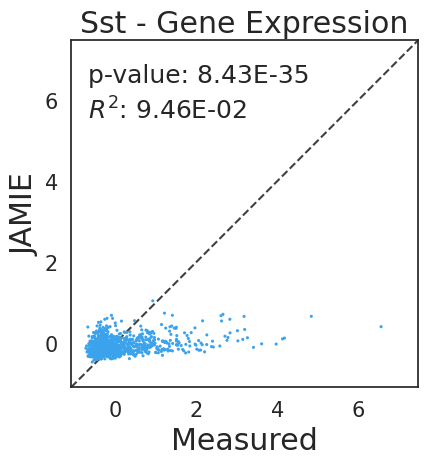

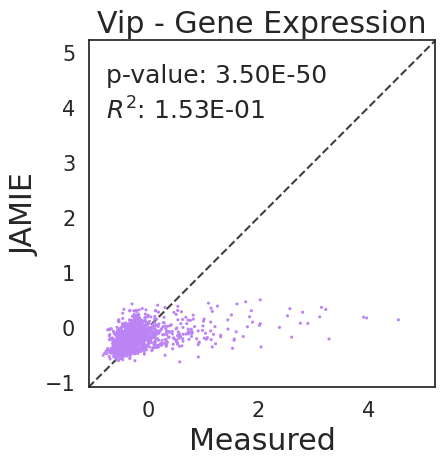

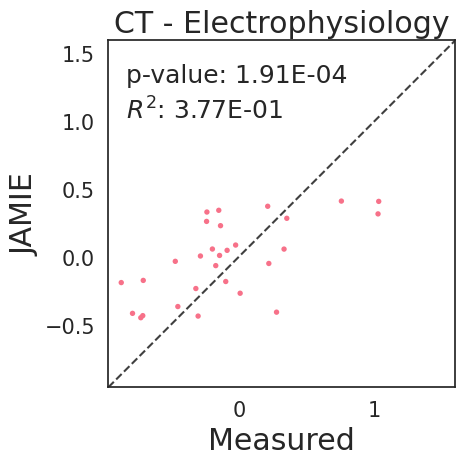

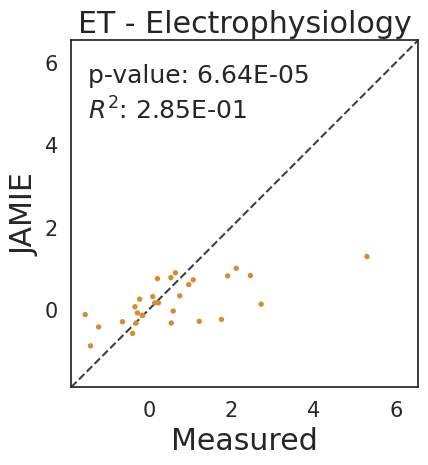

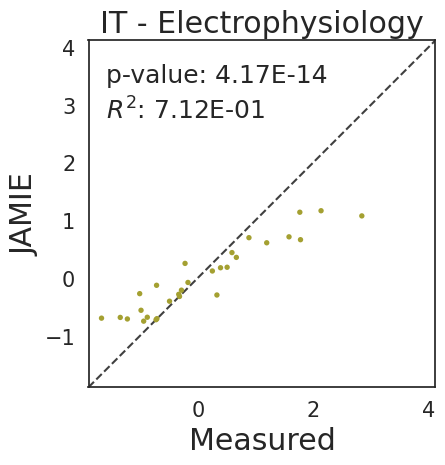

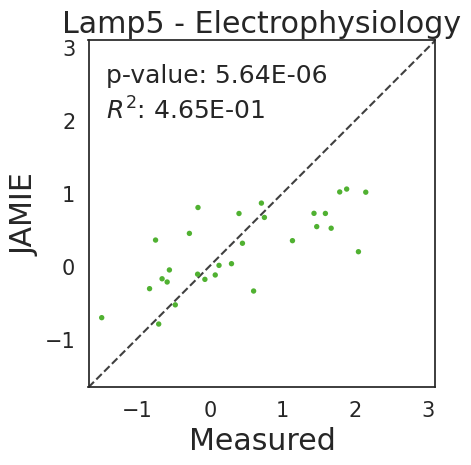

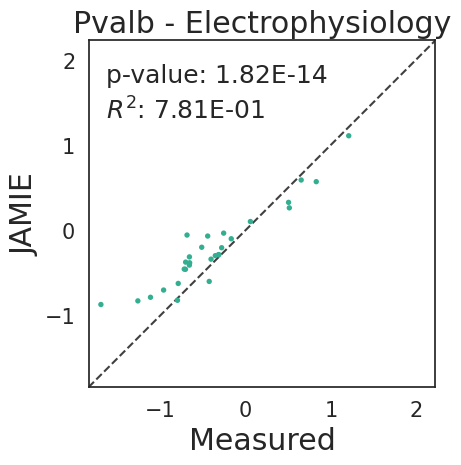

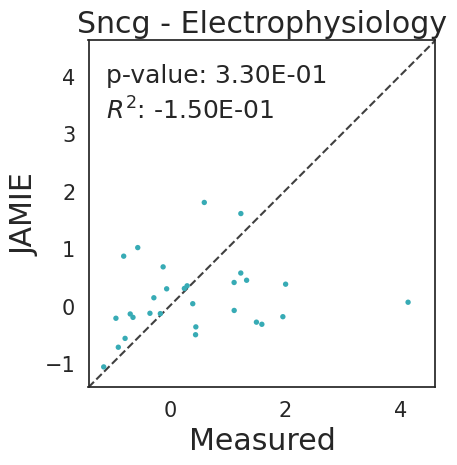

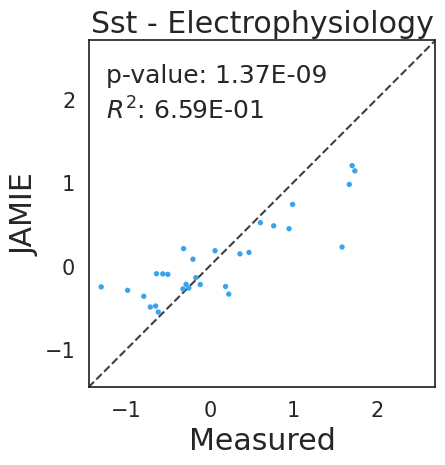

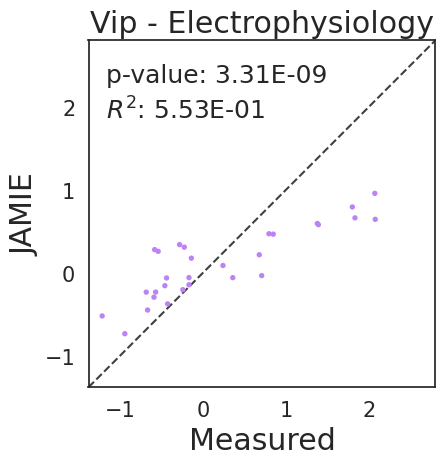

In [25]:
# Choose sample
for modality_idx in range(len(dataset)):
    for i, cell_type in enumerate(np.unique(labels[modality_idx][test_idx])):
        plt.figure(figsize=(5, 5))
        plot_sample(
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], dataset[modality_idx][test_idx]) if ct==cell_type]),
            np.array([np.array(row) for ct, row in zip(labels[modality_idx][test_idx], imputed_data[1][modality_idx]) if ct==cell_type]),
            imputed_names[1],
            modality_names[modality_idx],
            suptitle=cell_type,
            color=np.array(plt.rcParams['axes.prop_cycle'])[i]['color'])
        plt.tight_layout()
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
        plt.savefig(image_folder + dataset_name + f'-Sample{modality_idx}-{cell_type.replace("/", "_")}.svg', format='svg', bbox_inches='tight')
        plt.show()

/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Kcnc1: 0.33955422792801354
Tmem130: 0.3965794139320427
Upstroke.to.downstroke.ratio: 0.391913538211501
Max.number.of.APs: 0.3907212619465881


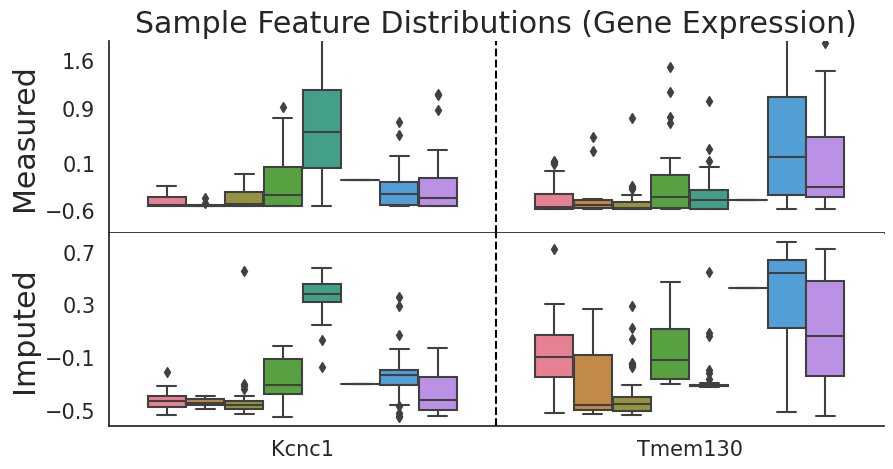

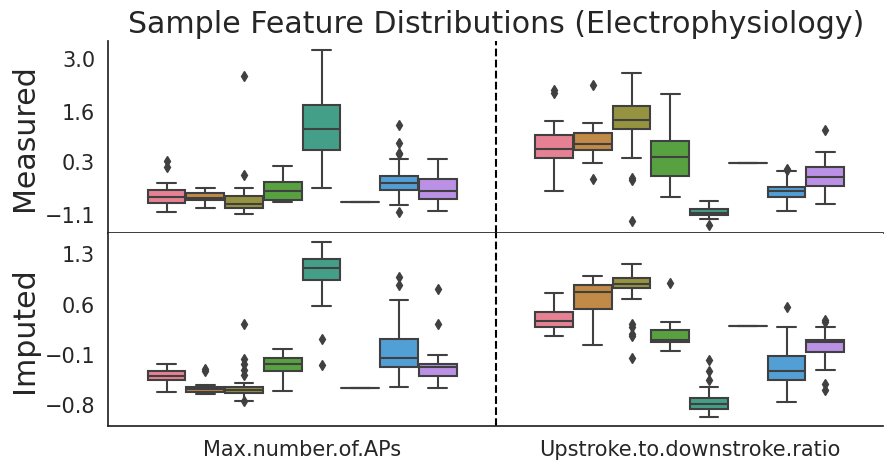

In [26]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Dist2.svg', format='svg', bbox_inches='tight')

/home/thema/miniconda3/envs/JAMIE/lib/python3.9/site-packages/scipy/spatial/distance.py:1249: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


Mean: 0.5209264081836341
Std: 0.2785471304688388
Mean: 0.4941566268172285
Std: 0.24105687871864268


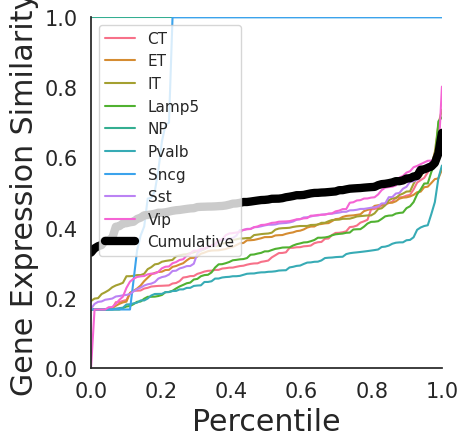

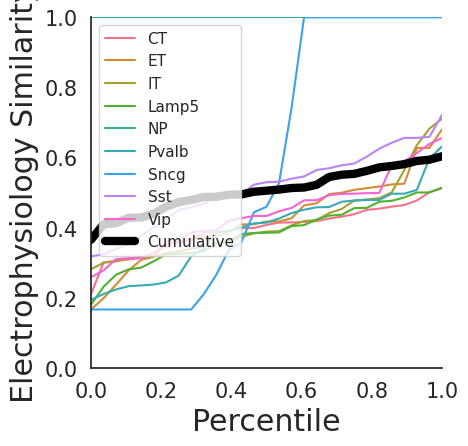

In [27]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], label_order=np.unique(labels), title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Sim1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], label_order=np.unique(labels), title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Sim2.svg', format='svg', bbox_inches='tight')

# Explanation

In [28]:
mod0, mod1 = 0, 1
current_jm = jm
analysis_base = f'{output_folder}JAMIE---{size_str}---'
analysis_str = analysis_base + 'sorted_genes'

In [29]:
# LTA
target_name = 'LTA'
Ly = current_jm.transform_one(dataset[mod1], mod1)
function = lambda x: current_jm.test_LabelTA([current_jm.transform_one(x, mod0), Ly], labels)
perf_function = lambda x, y: x
true = None

# Imputation
# target = sort_by_interest([dataset[mod1], current_jm.modal_predict(dataset[mod0], mod0)], limit=20, remove_outliers=True)[1][1]
# target_name = features[mod1][target] + '\nCorrelation'
# function = lambda x: current_jm.modal_predict(x, mod0)[:, target]
# true = dataset[mod1][:, target]
# from scipy.stats import pearsonr
# perf_function = lambda x, y: pearsonr(x, y)[0]

testing_idx = np.array(range(dataset[mod0].shape[1]))
# testing_idx = sort_by_interest([dataset[mod0], dataset[mod0]], limit=1000, remove_outliers=False)[1]
# testing_idx = np.random.choice(dataset[mod0].shape[0], 1000, replace=False)
# scan = None
scan = None

if not os.path.exists(analysis_str):
    baseline, performance, new_idx = evaluate_impact(function, perf_function, dataset[mod0], true, features[mod0], idx=testing_idx, scan=scan)
    argsort = np.argsort(performance)
    sorted_idx = new_idx[argsort]
    sorted_names = features[mod0][sorted_idx]
    sorted_names = np.array([s.replace(' ', '_') for s in sorted_names])
    sorted_perf = performance[argsort]
    
    file_contents = np.concatenate([sorted_idx.reshape((-1, 1)), sorted_names.reshape((-1, 1)), sorted_perf.reshape((-1, 1))], axis=1)
    file_contents_str = '\n'.join([' '.join([str(s) for s in r]) for r in file_contents]) + '\n'
    with open(analysis_str, 'w') as f:
        f.write(file_contents_str)
else:
    baseline = perf_function(function(dataset[mod0]), true)
    sorted_idx = []
    sorted_names = []
    sorted_perf = []
    with open(analysis_str, 'r') as f:
        for line in f:
            idx, names, perf = line[:-1].split(' ')
            sorted_idx.append(int(idx))
            sorted_names.append(str(names))
            sorted_perf.append(float(perf))
    sorted_idx, sorted_names, sorted_perf = np.array(sorted_idx), np.array(sorted_names), np.array(sorted_perf)
    performance = sorted_perf

Finding important features...
1286/1286 [||||||||||||||||||||||||||||||||||||||||||||||||||] - Current Best: 0.84272, Rimbp2
Done!


In [30]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {target_name}')
print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={target_name}')
importance = sorted_names[:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n, p in zip(importance, sorted_perf[:display]):
    print(f'{p:.5f}: https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target Electrophysiology Feature: LTA
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LTA
Important Gene Expression Features: Rimbp2, Cox5b, Itsn1, Mef2a, Arhgap32, Sorbs1, Tlk1, Bsn, Rpl23, Hecw1, Astn2, Map1a, Cadm3, Herc1, Mical2, Blcap, Gabrd, Pitpnc1, Snx3, Rapgef4
0.84272: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Rimbp2
0.84437: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Cox5b
0.84437: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Itsn1
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Mef2a
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Arhgap32
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Sorbs1
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Tlk1
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Bsn
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Rpl23
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Hecw1
0.84520: https://www.genecards.org/cgi-bin/carddisp.pl?gene=Astn

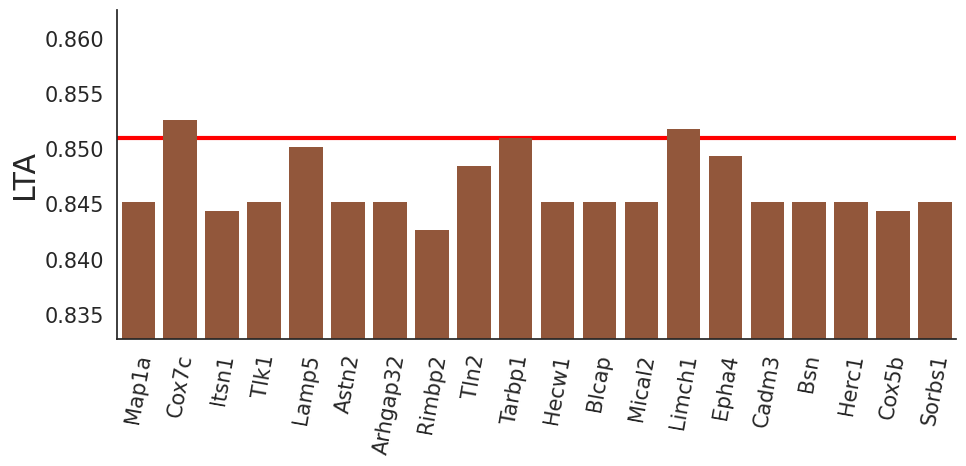

In [31]:
plt.figure(figsize=(10, 5))
plot_impact(sorted_perf, sorted_names, baseline, max_features=20, color=dataset_color)
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Analysis.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Analysis.svg', format='svg', bbox_inches='tight')